In [ ]:
!pip install xgboost scikit-learn imbalanced-learn matplotlib seaborn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/balanced_architecture_aware_anti_patterns.csv")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


Mounted at /content/drive


,file,repo,layer,architecture_pattern,architecture_confidence,loc,methods,classes,avg_cc,imports,...,has_data_access,has_http_handling,has_validation,has_transaction,dependency_direction,violates_layer_separation,anti_pattern,all_violations,severity,context_specific_label
0,CustomerApplication.java,services,service,layered,0.869881,40.083266,0.032199,0.036531,0.914509,7.943891,...,False,False,False,False,correct,False,tight_coupling_new_keyword,tight_coupling_new_keyword,medium,tight_coupling_new_keyword_in_layered_service
1,InventoryController.java,web,controller,layered,0.942029,44.993545,0.072984,0.000000,0.971595,12.074255,...,False,True,False,False,skip_layer,True,layer_skip_in_layered,layer_skip_in_layered,high,layer_skip_in_layered_in_layered_controller
2,PersonController.java,rieckpil,controller,layered,0.910334,20.964909,0.014034,0.002426,0.938622,5.073422,...,False,True,False,False,skip_layer,True,layer_skip_in_layered,layer_skip_in_layered,high,layer_skip_in_layered_in_layered_controller
3,HttpHeadersMethodArgumentResolver.java,yeauty,controller,mvc,1.000000,18.000000,0.000000,0.000000,1.000000,4.000000,...,False,False,False,False,unknown,False,clean,clean,low,clean_mvc_controller
4,DepartmentController.java,controller,controller,layered,0.810041,228.031315,0.096371,0.020633,1.016574,29.996473,...,True,True,False,True,correct,False,business_logic_in_controller_layered,business_logic_in_controller_layered,medium,business_logic_in_controller_layered_in_layere...


In [ ]:
import numpy as np

dependency_cols = [
    'controller_deps','service_deps','repository_deps','entity_deps',
    'adapter_deps','port_deps','usecase_deps','gateway_deps','total_cross_layer_deps'
]

for col in dependency_cols:
    if col in df.columns:
        df[col] = np.log1p(df[col])


In [ ]:
drop_cols = [
    'anti_pattern','file','repo','all_violations','context_specific_label',
    'severity','layer','dependency_direction'
]

X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y_raw = df['anti_pattern']

print("Training columns:", X.columns.tolist())


Training columns: ['architecture_pattern', 'architecture_confidence', 'loc', 'methods', 'classes', 'avg_cc', 'imports', 'annotations', 'controller_deps', 'service_deps', 'repository_deps', 'entity_deps', 'adapter_deps', 'port_deps', 'usecase_deps', 'gateway_deps', 'total_cross_layer_deps', 'has_business_logic', 'has_data_access', 'has_http_handling', 'has_validation', 'has_transaction', 'violates_layer_separation']


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label mapping: {'broad_catch': np.int64(0), 'business_logic_in_controller_layered': np.int64(1), 'clean': np.int64(2), 'framework_dependency_in_domain_hexagonal': np.int64(3), 'layer_skip_in_layered': np.int64(4), 'missing_port_adapter_in_hexagonal': np.int64(5), 'missing_transaction_in_layered': np.int64(6), 'no_validation': np.int64(7), 'tight_coupling_new_keyword': np.int64(8)}


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
numeric_cols = X_train.select_dtypes(include=['float64','int64']).columns.tolist()

X_train[numeric_cols] += np.random.normal(0, 0.01, X_train[numeric_cols].shape)
X_test[numeric_cols]  += np.random.normal(0, 0.01, X_test[numeric_cols].shape)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ['architecture_pattern']
boolean_cols = X_train.select_dtypes(include=['bool']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("bool", "passthrough", boolean_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=14,
        min_samples_split=4,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=90,
        max_depth=4,
        learning_rate=0.07,
        subsample=0.75,
        colsample_bytree=0.75,
        min_child_weight=5,
        reg_alpha=8,
        reg_lambda=8,
        gamma=3,
        eval_metric="mlogloss",
        random_state=42
    ),

    "LinearSVC": LinearSVC(
        C=1.2,
        class_weight="balanced",
        max_iter=7000
    )
}


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', model)
    ])

    cv_scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5, scoring='f1_macro'
    )

    results.append([name, cv_scores.mean(), cv_scores.std()])
    print(f"{name} → Mean F1: {cv_scores.mean():.4f} | Std: {cv_scores.std():.4f}")

df_results = pd.DataFrame(results, columns=["model","mean_f1","std"])
df_results


RandomForest → Mean F1: 0.9498 | Std: 0.0010
XGBoost → Mean F1: 0.8957 | Std: 0.0012
LinearSVC → Mean F1: 0.7793 | Std: 0.0033


,model,mean_f1,std
0,RandomForest,0.949790,0.001010
1,XGBoost,0.895731,0.001169
2,LinearSVC,0.779343,0.003342


In [ ]:
best_model_name = df_results.sort_values(by="mean_f1", ascending=False).iloc[0]["model"]
print("BEST MODEL:", best_model_name)

final_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', models[best_model_name])
])

final_model.fit(X_train, y_train)


BEST MODEL: RandomForest


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['architecture_pattern']),
                                                 ('bool', 'passthrough',
                                                  ['has_business_logic',
                                                   'has_data_access',
                                                   'has_http_handling',
                                                   'has_validation',
                                                   'has_transaction',
                                                   'violates_layer_separation']),
                                                 ('num', StandardScaler(),
                                                  ['architecture_confidence',
                                                   'loc', 'methods', 'classes',
                                                   'avg_cc', 'imports',
                                                   'annotations',
                                                   'controller_deps',
                                                   'service_deps',
                                                   'repository_deps',
                                                   'entity_deps',
                                                   'adapter_deps', 'port_deps',
                                                   'usecase_deps',
                                                   'gateway_deps',
                                                   'total_cross_layer_deps'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=14,
                                        min_samples_split=4, n_estimators=200,
                                        random_state=42))])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_enc = final_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_enc)
y_true = label_encoder.inverse_transform(y_test)

print("CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred))
print("CONFUSION MATRIX:")
print(confusion_matrix(y_true, y_pred))


CLASSIFICATION REPORT:
                                          precision    recall  f1-score   support

                             broad_catch       0.97      0.75      0.85      3138
    business_logic_in_controller_layered       0.91      0.99      0.95      3138
                                   clean       0.97      0.89      0.93      3139
framework_dependency_in_domain_hexagonal       0.95      1.00      0.97      3139
                   layer_skip_in_layered       1.00      1.00      1.00      3139
       missing_port_adapter_in_hexagonal       1.00      1.00      1.00      3138
          missing_transaction_in_layered       0.96      1.00      0.98      3139
                           no_validation       0.93      0.98      0.96      3138
              tight_coupling_new_keyword       0.91      0.96      0.93      3138

                                accuracy                           0.95     28246
                               macro avg       0.95      0.95      0.95  

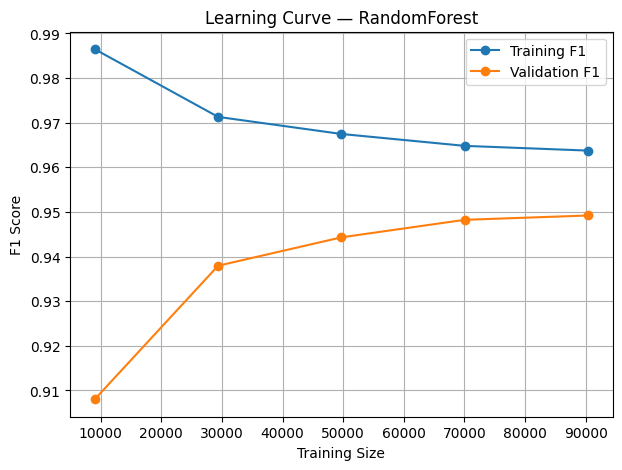

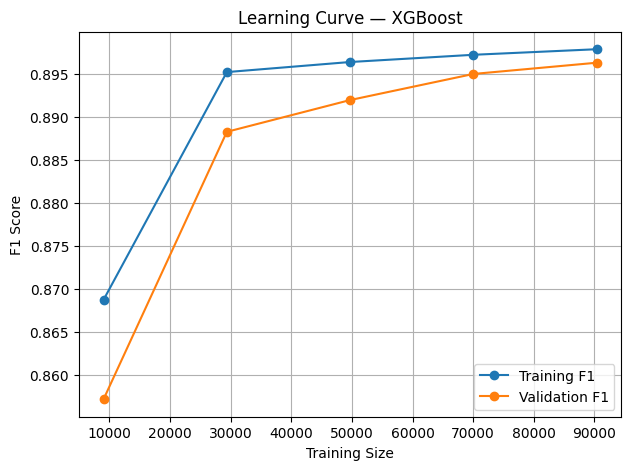

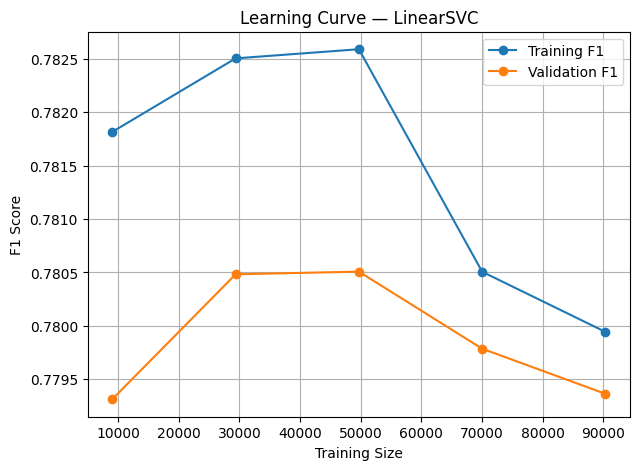

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

def plot_learning_curve(model, title):
    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', model)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        pipe, X_train, y_train,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, label="Training F1", marker='o')
    plt.plot(train_sizes, test_mean, label="Validation F1", marker='o')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for each model
for name, model in models.items():
    plot_learning_curve(model, f"Learning Curve — {name}")


In [ ]:
import joblib
joblib.dump({
    "model": final_model,
    "label_encoder": label_encoder
}, "architecture_aware_antipattern_model.joblib")

print("Model saved successfully.")


Model saved successfully.
